## Set up environment and fetch Files

In [1]:
#set up environment
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt
import os


import numpy as np
from pathlib import Path
import gzip, io
from qiime2 import Visualization

%matplotlib inline
##!rm -r data ###unappend this line if you want to wipe clean the data folder
data_dir = 'data'
safe = 'permanent_dir'
! mkdir -p data
! mkdir -p permanent

In [ ]:
#### fetch files from polybox
! wget -r -np -nH --cut-dirs=3 -R "index.html*" "https://polybox.ethz.ch/index.php/s/56JaAiKdGwioBKN/download" -O polybox_files.tar.gz
! tar -xzf polybox_files.tar.gz

#unzip polybox files
!mv polybox_files.tar.gz polybox_files.zip
!unzip polybox_files.zip
!rm polybox_files.zip

#untar MAGs files and store everything in data_dir
!tar -xzf applied_bioinformatics/Illumina_MAGs.tar.gz -C ./data
!tar -xzf applied_bioinformatics/PacBio_MAGs.tar.gz -C ./data
!mv applied_bioinformatics/merged_metadata_filtered.tsv ./data
!rm -r applied_bioinformatics

MANIFEST saved to: data/MANIFEST
  sample-id                                mag-id  \
0      M004  a49f7594-90c0-474c-8018-a270b85443ad   
1      M004  c111a073-4c32-470b-a3fc-510d64e7df13   
2      M004  41e84282-3222-49cb-8976-c309484b965c   
3      M004  697d0481-e88e-4957-996a-e221e9089b06   
4      M004  0f4ce2d0-9b0c-4ce8-bf58-17506e2bd322   

                                            filename  
0  /home/jovyan/Interplanetary_Microbiome/data/Pa...  
1  /home/jovyan/Interplanetary_Microbiome/data/Pa...  
2  /home/jovyan/Interplanetary_Microbiome/data/Pa...  
3  /home/jovyan/Interplanetary_Microbiome/data/Pa...  
4  /home/jovyan/Interplanetary_Microbiome/data/Pa...  
Index(['sample-id', 'mag-id', 'filename'], dtype='object')
Checking short data:
  Max size: 105229916 bp
  Min size: 0 bp
  Mean size: 1472381.8440366972 bp
  Number of sequences: 545
Checking long data:
  Max size: 26029257 bp
  Min size: 200069 bp
  Mean size: 961954.9648526077 bp
  Number of sequences: 882
Wrote g

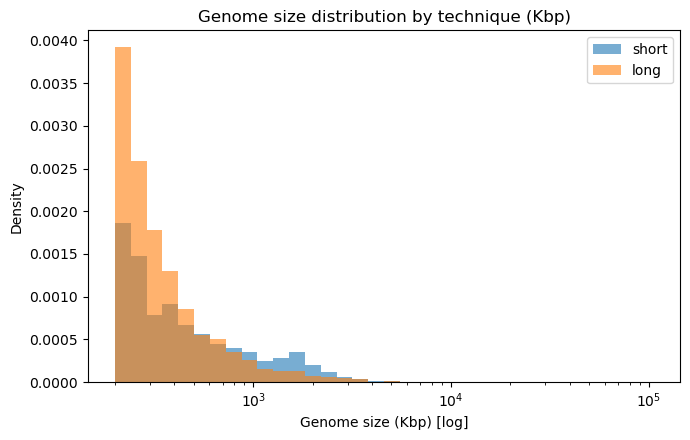

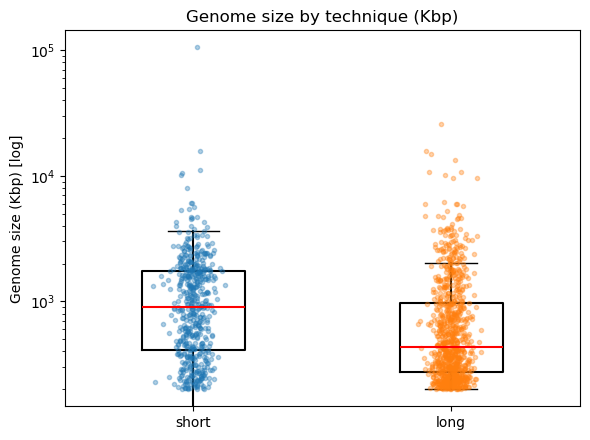

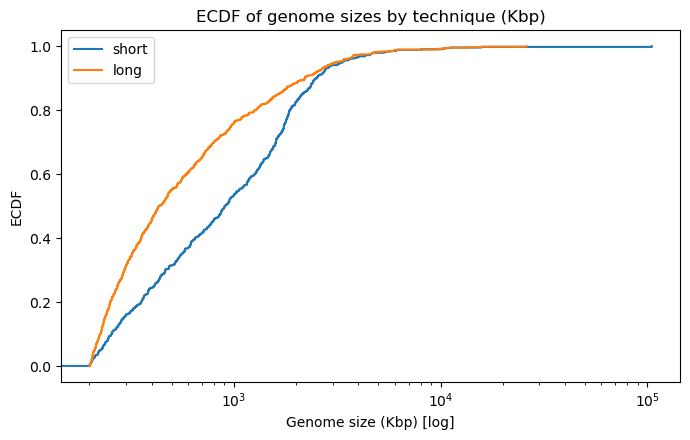

In [2]:
# Create metadata df for exploration
from uuid import uuid4

# load metadata (sample-level metadata table, indexed by sample-id)
metadata_df = pd.read_csv(f"{data_dir}/merged_metadata_filtered.tsv", sep="\t", index_col=0)

# ---------------------------------------------------------------------
# 1) Rename all FASTA files with UUIDs
#    - This avoids collisions if different samples had identical filenames.
#    - We traverse all subdirectories under data_dir and rename *.fa / *.fasta.
# ---------------------------------------------------------------------
for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for file in os.listdir(sample_path):
            if file.endswith((".fa", ".fasta")):
                old_path = os.path.join(sample_path, file)
                # use a UUID as a new filename (still with .fa extension)
                new_path = os.path.join(sample_path, f"{uuid4()}.fa")
                os.rename(old_path, new_path)

# ---------------------------------------------------------------------
# 2) Build a manifest-like table linking sample-id, MAG ID and filename
#    - We walk the directory tree again, collect all FASTA files,
#      and only keep entries where sample_id exists in metadata_df.
# ---------------------------------------------------------------------
records = []

for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for f in os.listdir(sample_path):
            if f.endswith((".fa", ".fasta")):
                abs_path = os.path.abspath(os.path.join(sample_path, f))
                # only include sample IDs that are present in the metadata
                if sample_id in metadata_df.index:
                    mag_id = os.path.splitext(f)[0]  # filename without extension
                    records.append((sample_id, mag_id, abs_path))

# build dataframe
manifest_df = pd.DataFrame.from_records(records, columns=["sample-id", "mag-id", "filename"])

# save as MANIFEST (comma-separated, no index; QIIME2 manifest is typically CSV)
manifest_path = os.path.join(data_dir, "MANIFEST")
manifest_df.to_csv(manifest_path, sep=",", index=False)

print(f"MANIFEST saved to: {manifest_path}")
print(manifest_df.head())
print(manifest_df.columns)

# ---------------------------------------------------------------------
# 3) Genome size distribution
#    - We compute total sequence length (bp) for each MAG FASTA file,
#      build a per-MAG DataFrame, and explore genome size statistics.
# ---------------------------------------------------------------------

## Genome size distribution

# Recursively list FASTA(-like) files under a root directory.
def list_fasta_files(root):
    root = Path(root)
    exts = {".fa", ".fna", ".fasta"}
    out = []
    for p in root.rglob("*"):
        if p.is_file():
            suf = p.suffix.lower()
            # handle compressed filenames like .fa.gz
            suf2 = "".join(p.suffixes[-2:]).lower()
            if suf in exts or suf2 in {".fa.gz", ".fna.gz", ".fasta.gz"}:
                out.append(p)
    return out

# Return total sequence length in bp for a FASTA file. Supports plain and gzipped.
def fasta_total_length(path):
    total = 0
    open_fn = gzip.open if str(path).endswith(".gz") else open
    # Use text mode with utf-8 fallback and ignore problematic characters
    with open_fn(path, "rt", errors="ignore") as fh:
        for line in fh:
            if not line or line.startswith(">"):
                continue
            total += len(line.strip())
    return total

# Build DataFrame with columns: mag_id, size_bp, _tech, path.
def build_df_from_folder(folder, tech_label):
    files = list_fasta_files(folder)
    rows = []
    for f in files:
        # derive MAG ID from filename stem
        mag_id = f.stem.replace(".fa","").replace(".fna","").replace(".fasta","")
        size_bp = fasta_total_length(f)
        rows.append((mag_id, size_bp, tech_label, str(f)))
    return pd.DataFrame(rows, columns=["mag_id", "size_bp", "_tech", "path"])

# Define the input folders for Illumina and PacBio MAGs
illu_dir = Path(data_dir) / "Illumina_MAGs"
pacb_dir = Path(data_dir) / "PacBio_MAGs"

# 1) Build df_mag: concatenated genome-size table for both techniques
#    Here we label Illumina as "short" and PacBio as "long".
df_ill = build_df_from_folder(illu_dir, "short")  # Illumina = short-read
df_pac = build_df_from_folder(pacb_dir, "long")   # PacBio  = long-read
df_mag = pd.concat([df_ill, df_pac], ignore_index=True)

# also compute genome size in Mbp for convenience / metadata export
df_mag["_size_mbp"] = df_mag["size_bp"] / 1e6

# Helper to print basic statistics for each technique
def check_tech_label(df, tech_label):
    print(f"Checking {tech_label} data:")
    print(f"  Max size: {df['size_bp'].max()} bp")
    print(f"  Min size: {df['size_bp'].min()} bp")
    print(f"  Mean size: {df['size_bp'].mean()} bp")
    print(f"  Number of sequences: {len(df)}")

# Print Illumina and PacBio genome size statistics
check_tech_label(df_ill, "short")  # Illumina
check_tech_label(df_pac, "long")   # PacBio

# ---------------------------------------------------------------------
# 4) Build a QIIME 2–ready metadata TSV with genome size information
#    - This table is later visualized with `qiime metadata tabulate`.
# ---------------------------------------------------------------------
meta = df_mag.rename(columns={
    "mag_id":   "sample-id",
    "_tech":    "technique",
    "_size_mbp":"genome_size_mbp"
})[["sample-id", "technique", "genome_size_mbp", "size_bp", "path"]]

meta.to_csv(f"{data_dir}/genome_sizes_metadata.tsv", sep="\t", index=False)
print("Wrote genome_sizes_metadata.tsv")

# Turn the metadata into an interactive QIIME 2 visualization
! qiime metadata tabulate \
  --m-input-file $data_dir/genome_sizes_metadata.tsv \
  --o-visualization $data_dir/genome_sizes_table.qzv

Visualization.load(f"{data_dir}/genome_sizes_table.qzv")

# ---------------------------------------------------------------------
# 5) Visual exploration of genome size distributions (Kbp, log scale)
#    - Histogram, boxplot, and ECDF by sequencing technique.
# ---------------------------------------------------------------------

# --- Plot in Kbp ---

# 0) Convert to Kbp
df_k = df_mag.copy()
df_k["_size_kbp"] = df_k["size_bp"] / 1e3  # size in Kbp

# knobs to control plotting behavior
LOG = True               # set True to use log-scale axes
FOCUS_MAX_KBP = None     # set None for full range; 1000 Kbp = 1 Mbp

# 1) Summary statistics per technique (useful for figure captions)
summary = (
    df_k.groupby("_tech")["_size_kbp"]
        .agg(n="count", mean="mean", median="median",
             q25=lambda s: s.quantile(0.25),
             q75=lambda s: s.quantile(0.75),
             min="min", max="max")
        .round(2)
)
print(summary)

# 2) Histogram of genome sizes by technique
plt.figure(figsize=(7, 4.5))
x = df_k["_size_kbp"].to_numpy()
xmin = max(1, x[x>0].min()) if LOG else df_k["_size_kbp"].min()
xmax = df_k["_size_kbp"].max()
bins = (np.logspace(np.log10(xmin), np.log10(xmax), 35)
        if LOG else np.linspace(xmin, np.quantile(x, 0.99), 35))

for t in ["short", "long"]:
    vals = df_k.loc[df_k["_tech"] == t, "_size_kbp"].values
    plt.hist(vals, bins=bins, alpha=0.6, label=t, density=True)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("Density")
plt.title("Genome size distribution by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Boxplot + jittered points by technique
plt.figure(figsize=(6, 4.5))
tech_order = ["short", "long"]
data_for_box = [df_k.loc[df_k["_tech"]==t, "_size_kbp"].values for t in tech_order]

# Adjust boxplot appearance
plt.boxplot(
    data_for_box,
    labels=tech_order,
    showfliers=False,
    widths=0.4,
    notch=False,
    patch_artist=False,  # no fill color
    boxprops=dict(linewidth=1.5, color='black'),   # bold black border
    medianprops=dict(linewidth=1.5, color='red'),  # red median line
    whiskerprops=dict(linewidth=1.5, color='black')  # bold whiskers
)

# Add jittered individual points on top of the boxplot
rng = np.random.default_rng(0)
for xi, t in enumerate(tech_order, start=1):
    vals = df_k.loc[df_k["_tech"]==t, "_size_kbp"].values
    jit = rng.normal(0, 0.04, size=len(vals))
    plt.plot(np.full_like(vals, xi) + jit, vals, "o", ms=3, alpha=0.35)

if LOG:
    plt.yscale("log")
if FOCUS_MAX_KBP is not None:
    plt.ylim(0, FOCUS_MAX_KBP)
plt.ylabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.title("Genome size by technique (Kbp)")
plt.tight_layout()
plt.show()

# 4) ECDF (empirical cumulative distribution function) by technique
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(7, 4.5))
for t in tech_order:
    x_ecdf, y_ecdf = ecdf(df_k.loc[df_k["_tech"]==t, "_size_kbp"].values)
    plt.step(x_ecdf, y_ecdf, where="post", label=t)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("ECDF")
plt.title("ECDF of genome sizes by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()
